# Tree Image Segmentation by UNet 

In [24]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import torch
import glob
import pandas as pd
import random
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
from torchvision.transforms import functional as F
from torchvision import transforms, datasets
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset, random_split
from matplotlib import patches

## Dataset

In [22]:

class TreeDataset(Dataset):
    def __init__(self, image_dir, xml_dir, transform=None, image_size=(512, 512)):
        """
        Args:
            image_dir (str): Directory with all the .tif images.
            xml_dir (str): Directory with all the .xml annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
            image_size (tuple): Size to resize images and masks to.
        """
        self.image_dir = image_dir
        self.xml_dir = xml_dir
        self.transform = transform
        self.image_size = image_size

        # Find common files with both image and annotation
        images = {os.path.splitext(f)[0]: f for f in os.listdir(image_dir) if f.endswith('.tif')}
        annotations = {os.path.splitext(f)[0]: f for f in os.listdir(xml_dir) if f.endswith('.xml')}
        self.common_files = list(set(images.keys()).intersection(set(annotations.keys())))

    def get_bounding_boxes(self, xml_file):
        """
        Parse the XML file to extract bounding boxes.
        Args:
            xml_file (str): Path to the XML file.
        Returns:
            List[Tuple[int, int, int, int]]: List of bounding boxes (xmin, ymin, xmax, ymax).
        """
        tree = ET.parse(xml_file)
        root = tree.getroot()

        boxes = []
        for obj in root.findall('object'):
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            boxes.append((xmin, ymin, xmax, ymax))

        return boxes

    def __len__(self):
        return len(self.common_files)

    def __getitem__(self, idx):
        # Get the filename without extension
        file_id = self.common_files[idx]

        # Load image
        image_path = os.path.join(self.image_dir, file_id + ".tif")
        image = Image.open(image_path).convert("RGB")
        original_size = image.size  # Save the original size (width, height)
        image = image.resize(self.image_size, Image.BILINEAR)

        # Load and parse the XML annotation
        xml_path = os.path.join(self.xml_dir, file_id + ".xml")
        boxes = self.get_bounding_boxes(xml_path)

        # Scale bounding boxes to match the resized image dimensions
        x_scale = self.image_size[0] / original_size[0]
        y_scale = self.image_size[1] / original_size[1]
        scaled_boxes = [
            (int(xmin * x_scale), int(ymin * y_scale), int(xmax * x_scale), int(ymax * y_scale))
            for (xmin, ymin, xmax, ymax) in boxes
        ]

        # Apply any transformations
        if self.transform:
            image = self.transform(image)

        return image, scaled_boxes

    def show_with_annotations(self, idx):
        """
        Display the image with bounding box annotations.
        Args:
            idx (int): Index of the image to display.
        """
        # Load image and bounding boxes
        image, boxes = self[idx]
        image = np.array(image)

        # Display the image
        fig, ax = plt.subplots(1)
        ax.imshow(image)

        # Plot bounding boxes
        for (xmin, ymin, xmax, ymax) in boxes:
            rect = patches.Rectangle(
                (xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth=2, edgecolor='r', facecolor='none'
            )
            ax.add_patch(rect)

        plt.axis('off')
        plt.show()


# Experiment Design: Split into Train, Validation, and Test Sets
def create_datasets(image_dir, xml_dir, transform=None, image_size=(512, 512), seed=42):
    # Create a single dataset instance for all matched images
    full_dataset = TreeDataset(image_dir=image_dir, xml_dir=xml_dir, transform=transform, image_size=image_size)

    # Set the random seed for reproducibility
    torch.manual_seed(seed)

    # Calculate lengths for train, validation, and test splits
    num_total = len(full_dataset)
    num_test = int(0.2 * num_total)
    num_val = int(0.2 * (num_total - num_test))
    num_train = num_total - num_test - num_val

    # Perform the random split
    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [num_train, num_val, num_test])
    return train_dataset, val_dataset, test_dataset

Training set size: 125
Validation set size: 31
Test set size: 38


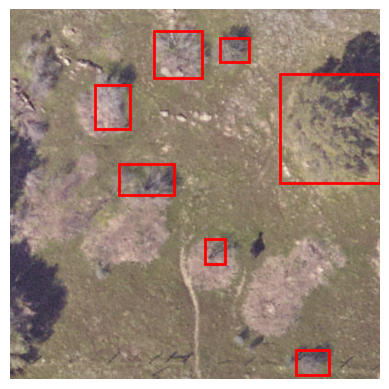

In [ ]:
from torchvision import transforms

# Define any image transformations

# Example usage
image_dir = "../../static/weecology-NeonTreeEvaluation/evaluation/RGB"
xml_dir = "../../static/weecology-NeonTreeEvaluation/annotations"

# Split datasets and create loaders
train_dataset, val_dataset, test_dataset = create_datasets(image_dir, xml_dir, transform=None)

# Verify dataset sizes
print("Training set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Test set size:", len(test_dataset))

# Example of showing an image with annotations
train_dataset.dataset.show_with_annotations(train_dataset.indices[0])  # Access the underlying dataset in the split

## Image Data Loader

In [26]:
from torch.utils.data import DataLoader

# Define the batch size for training, validation, and testing
batch_size = 16  # Adjust based on your memory capacity and model requirements

# Create DataLoader instances for each dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

## UNet Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder path
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder path
        self.dec4 = self.upconv_block(1024, 512)
        self.dec3 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(256, 128)
        self.dec1 = self.upconv_block(128, 64)
        
        # Output layer
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)
    
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
    
    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            self.conv_block(out_channels, out_channels)
        )
    
    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, kernel_size=2))
        enc3 = self.enc3(F.max_pool2d(enc2, kernel_size=2))
        enc4 = self.enc4(F.max_pool2d(enc3, kernel_size=2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2))
        
        # Decoder path
        dec4 = self.dec4(torch.cat([F.interpolate(bottleneck, scale_factor=2), enc4], dim=1))
        dec3 = self.dec3(torch.cat([F.interpolate(dec4, scale_factor=2), enc3], dim=1))
        dec2 = self.dec2(torch.cat([F.interpolate(dec3, scale_factor=2), enc2], dim=1))
        dec1 = self.dec1(torch.cat([F.interpolate(dec2, scale_factor=2), enc1], dim=1))
        
        # Output layer
        return torch.sigmoid(self.out_conv(dec1))  # Use sigmoid for binary segmentation

# Initialize the model
model = UNet(in_channels=3, out_channels=1)

## Training

In [ ]:
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Hyperparameters
num_epochs = 20
learning_rate = 0.001
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for segmentation
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training and Validation Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Testing Loop
model.eval()
test_loss = 0
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")